In [64]:
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda,Dropout
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [65]:
# FETCH DATA
measurments_path = "/Measurments/recording.csv"
image_path = "/Images/"

data_paths=[]
for folder in os.listdir('../Training_data'):
    data_paths.append("../Training_data/"+folder)

print(data_paths)


['../Training_data/1', '../Training_data/0']


In [66]:
measurment_recordings = []
for path in data_paths:
    measurment_recording = pd.read_csv(path + measurments_path )
    measurment_recordings.append(measurment_recording)

In [67]:
"""lines = []
with open(data_path) as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # Skip header
        for line in reader:
            lines.append(line)"""

'lines = []\nwith open(data_path) as csvfile:\n        reader = csv.reader(csvfile)\n        next(reader) # Skip header\n        for line in reader:\n            lines.append(line)'

In [68]:
print(measurment_recordings[0])

     Throttle  Reverse  at_TL  frame  Manual  Hand brake     Steer  \
0    1.000000    False  False    711   False       False -0.048235   
1    1.000000    False  False    721   False       False -0.048226   
2    1.000000    False  False    731   False       False -0.048226   
3    1.000000    False  False    741   False       False -0.048226   
4    1.000000    False  False    752   False       False -0.041451   
5    1.000000    False  False    761   False       False -0.027005   
6    1.000000    False  False    771   False       False -0.019909   
7    0.000000    False  False    781   False       False -0.062947   
8    0.000000    False  False    791   False       False -0.074003   
9    0.000000    False  False    801   False       False -0.016585   
10   1.000000    False  False    812   False       False  0.007624   
11   1.000000    False  False    821   False       False  0.005332   
12   0.880209    False  False    831   False       False -0.002572   
13   0.000000    Fal

In [69]:

image_recordings = []
for j, measurment_recording in enumerate(measurment_recordings):
    image_recording = []
    for index, row in measurment_recording.iterrows(): 
        
        # Add padding to path
        l = len(str(row["frame"]))
        pad = ''
        for i in range(8 - l):
            pad += '0'
            
        # Fetch image
        file_path = data_paths[j] + image_path + pad + str(row["frame"]) +'.png'
        img = cv2.imread(file_path)
        if len(img) == 0:
            print("Error fetching image")
        img = img[..., ::-1]
        #img = cv2.resize(oriimg,(160,90))
        image_recording.append(img)
    image_recordings.append(image_recording)
    

In [70]:
print(len(measurment_recordings))
print(len(image_recordings))
measurments = pd.concat(measurment_recordings, ignore_index=True)
images = []
for i in range(len(image_recordings)):
    if len(measurment_recordings) != len(image_recordings):
        print("DIFFERENT LENGTS")
    #if i != 0:
        #measurments.append(measurment_recordings[i], ignore_index=True)
    images.extend(image_recordings[i])
        
print(len(measurments))
print(len(images))


2
2
1915
1915


In [71]:
### NB Not needed when using tf.images.rgb2hsv
hsv=True
def normalize(x):
    if hsv:
        return x
    return np.divide(x, 255)-0.5


In [125]:

split = train_test_split(measurments, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
trainY = trainAttrX.loc[:,["Steer","Speed", "Direction"]]
testY = testAttrX.Steer
print(trainY)

         Steer      Speed              Direction
1387 -0.007192  17.863364  RoadOption.LANEFOLLOW
1874 -0.001299  21.819660  RoadOption.LANEFOLLOW
543  -0.001702  17.377715  RoadOption.LANEFOLLOW
478   0.000000   0.000000  RoadOption.LANEFOLLOW
741   0.000000   0.000000  RoadOption.LANEFOLLOW
1242  0.041600  21.462657  RoadOption.LANEFOLLOW
774   0.000000   0.000000  RoadOption.LANEFOLLOW
1449  0.101709  17.145262  RoadOption.LANEFOLLOW
1177  0.000406  18.662720  RoadOption.LANEFOLLOW
519   0.001977  20.744990       RoadOption.RIGHT
1263  0.000000   0.000000  RoadOption.LANEFOLLOW
310  -0.000403  17.891960  RoadOption.LANEFOLLOW
56    0.007621  21.766756  RoadOption.LANEFOLLOW
1033  0.001250  19.401060  RoadOption.LANEFOLLOW
1767  0.599848  18.333319       RoadOption.RIGHT
1236 -0.051803  19.411471  RoadOption.LANEFOLLOW
1307  0.296503  21.572490  RoadOption.LANEFOLLOW
631   0.000000   0.000000  RoadOption.LANEFOLLOW
43   -0.099460  20.111116  RoadOption.LANEFOLLOW
100   0.000289  17.4

In [116]:
"""X_train, y_train, labels_train = [],[],[]
X_valid, y_valid, labels_valid = [],[],[]

split = int(len(lines) - len(lines)/4)
print(" Training on " + str(split) + " and validating on " + str(len(lines)-split))
for img, line in zip(images[:split], lines[:split]):
    X_train.append(normalize(np.array(img, dtype=float)))
    y_train.append(line[6])
for img, line in zip(images[split:], lines[split:]):
    X_valid.append(normalize(np.array(img, dtype=float)))
    y_valid.append(line[6])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)"""

'X_train, y_train, labels_train = [],[],[]\nX_valid, y_valid, labels_valid = [],[],[]\n\nsplit = int(len(lines) - len(lines)/4)\nprint(" Training on " + str(split) + " and validating on " + str(len(lines)-split))\nfor img, line in zip(images[:split], lines[:split]):\n    X_train.append(normalize(np.array(img, dtype=float)))\n    y_train.append(line[6])\nfor img, line in zip(images[split:], lines[split:]):\n    X_valid.append(normalize(np.array(img, dtype=float)))\n    y_valid.append(line[6])\nX_train = np.array(X_train)\ny_train = np.array(y_train)\nX_valid = np.array(X_valid)\ny_valid = np.array(y_valid)'

-0.02700536884367466
image_shape: (90, 160, 3)


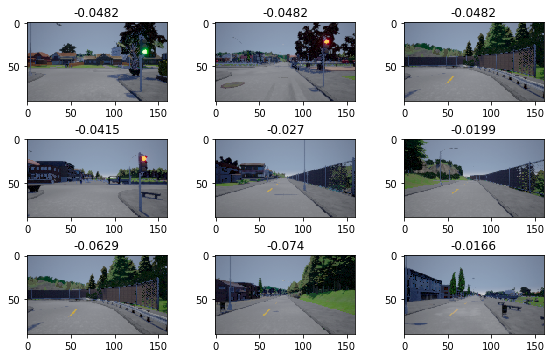

In [74]:
print(measurments.loc[5, "Steer"])
print("image_shape: " + str(trainImagesX[0].shape))
fig = plt.figure(figsize=(8,5))
for i in range(1,10):
    r = np.random.randint(len(images))
    img = images[r]
    img = img
    #img = ((img+0.5))
    #img = img[...,::-1]
    #TODO
    steering = round(float(measurments.loc[i, "Steer"]), 4)
    fig.add_subplot(3,3,i, title=steering)
    imgplot = plt.imshow(img)
fig.tight_layout()
plt.show()

In [75]:
def hsv_convert(x):
    import tensorflow as tf
    return tf.image.rgb_to_hsv(x)

In [126]:
print([1.0] * 8 + [0.7] * 2 + [0.5] * 2 + [0.5] * 1 + [0.5, 1.] * 5)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.7, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0]


In [ ]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
    x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model


In [127]:
print((2,) + (160,90,3))

(2, 160, 90, 3)


In [11]:
model = Sequential()
model.add(Lambda(hsv_convert, input_shape=(90,160,3)))
model.add(Conv2D(24,(5,5), strides=(2,2), activation="elu"))
model.add(Conv2D(36,(5,5), strides=(2,2), activation="elu"))
model.add(Conv2D(48,(5,5), strides=(2,2), activation="elu"))
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation="elu"))
model.add(Dense(50, activation="elu"))
model.add(Dense(10, activation="elu"))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
"""model = Sequential()
model.add(Lambda(hsv_convert, input_shape=(180,320, 3)))
model.add(Conv2D(3,(1,1), activation="elu"))

model.add(Conv2D(32,(3,3), activation="elu"))
model.add(Conv2D(32,(3,3), activation="elu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), activation="elu"))
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3), activation="elu"))
model.add(Conv2D(128,(3,3), activation="elu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(100, activation="elu"))
model.add(Dense(64, activation="elu"))
model.add(Dense(16, activation="elu"))
model.add(Dense(1))
"""

'model = Sequential()\nmodel.add(Lambda(hsv_convert, input_shape=(180,320, 3)))\nmodel.add(Conv2D(3,(1,1), activation="elu"))\n\nmodel.add(Conv2D(32,(3,3), activation="elu"))\nmodel.add(Conv2D(32,(3,3), activation="elu"))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv2D(64,(3,3), activation="elu"))\nmodel.add(Conv2D(64,(3,3), activation="elu"))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv2D(128,(3,3), activation="elu"))\nmodel.add(Conv2D(128,(3,3), activation="elu"))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.5))\n\n\nmodel.add(Flatten())\nmodel.add(Dense(100, activation="elu"))\nmodel.add(Dense(64, activation="elu"))\nmodel.add(Dense(16, activation="elu"))\nmodel.add(Dense(1))\n'

In [13]:
checkpointer = ModelCheckpoint(filepath="./checkpoints/model-{epoch:02d}.hdf5", verbose=1)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [14]:
model.fit(
    X_train, 
    y_train,
    batch_size=8,
    validation_data=(X_valid, y_valid),
    shuffle=True,
    epochs=2,
    verbose=1)#, callbacks=[checkpointer])

#model.save('model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 16 samples, validate on 5 samples
Epoch 1/2
16/16 [==============================] - 2s 97ms/step - loss: 186.6297 - acc: 0.0625 - val_loss: 0.3176 - val_acc: 0.0000e+00
Epoch 2/2
16/16 [==============================] - 0s 788us/step - loss: 0.2536 - acc: 0.6250 - val_loss: 0.3642 - val_acc: 0.0000e+00


In [15]:
print(model.predict(X_valid[4].reshape(1,90,160,3), batch_size=1))
print(y_valid[4])

[[0.61438483]]
0.0
